# Using Google Trends Index and High-frequency State-level Data to Predict National Unemployment Rates

A common issue with macro-economic data is that it is reported at low frequencies, generally quarterly: GDP and unemployment data are the most prominent examples of such macroeconomic indicators. However, policy makers, financial institutions and investors are often interested in having more frequent data on these indicators to be able to make more informed decisions in their respective fields.

In this exercise, I will focus on unemployment rates specifically. Previous literature has forecasted unemployment rates using either structural models (such as DSGE models), or non-structural ones which make use of some econometric tools (such as VAR models) to create predictive models. In a 2017 paper, [CH17](#cookhall2017) use multiple neural network architectures to predict civilian unemployment rates in the US using solely the unemployment rate series. The neural networks that [CH17](#cookhall2017) use are LSTM, Convolutional, Fully Connected and Encoder-Decoder.

Instead, I use a simpler architecture, Multi-Layer Perceptron, and expand their research by using the following data:
  - **State-level monthly unemployment data** from the Bureau of Labour Statistics. This data is retrieved using the Quandl API, and is expressed in percentages.
  - **Google Trends Index for unemployment-related keywords**. This data is expressed as a number from 1 to 100, where 100 represents the popularity of the keyword relative to other word searches within a period and a given location. 
  
The Google trends method for predicting unemployment is inspired by the The Research Institute of the Finnish Economy, which uses unemployment-related keywords to make nowcasts of European unemployment rates ([KU16](#tuhkuri2016)).

To test whether the Google trends data truly has any predictive power, I first run a [model](#Model-1) with state-level unemployment data which predicts the US national unemployment rate. Then, I use a [model](#Model-2) which includes Google trends index results for every US state. Lastly, in [model 3](#Model-3) I include present and past months of state unemployment and Google Index data to make predictions.

**Findings:**
1. Using Google Trends data reduces the mean squared error (MSE) at every forecast horizon (1-, 2-, and 3- month).
1. Adding historical state unemployment and Google Index data to the model considerably improves the prediction. 


### References

<a id='cookhall2017'></a>
\[CH17\] Thomas R. Cook and Aaron Smalter Hall (2017) Macroeconomic Indicator Forecasting with Deep Neural Networks. 

<a id='tuhkuri2016'></a>
\[KU16\]  Tuhkuri, Joonas (2016) ETLAnow: A Model for Forecasting with Big Data – Forecasting Unemployment with Google Searches in Europe.


## Download and Clean Data



### Unemployment Data

> First, I use Quandl's API to download monthly unadjusted unemployment rate data for each US state since 2010.  I choose January 2010 as my starting data because Quandl's access to Bureau of Labour Statistics data is restricted to 2010-present.  



In [0]:
%%capture
!pip install quandl 
import quandl 

In [0]:
# Get US national monthly unadjusted unemployment rate data 
quandl.ApiConfig.api_key = '2BYtKNrxRuVRhzkA9_2s'
unrate_us = quandl.get('FRED/UNRATE', start_date='2010-01-01', end_date='2019-04-01')
unrate_us.columns = ["US"]
unrate_us.index = unrate_us.index.strftime("%Y-%m")

In [0]:
# Second, we get the monthly state unemployment data 
codes_states = ['01', '02', '04', '05', '06', '08', '09', '10', '11', '12',
              '13', '15', '16', '17', '18', '19', '20', '21', '22', '23',
              '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', 
              '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', 
              '45', '46', '47', '48', '49', '50', '51', '53', '54', '55', 
               '56']
list_states = ("Alabama, Alaska, Arizona, Arkansas, California, "
       "Colorado, Connecticut, Delaware, District of Columbia, "
       "Florida, Georgia, Hawaii, Idaho, Illinois, Indiana, Iowa, "
       "Kansas, Kentucky, Louisiana, Maine, Maryland, Massachusetts, "
       "Michigan, Minnesota, Mississippi, Missouri, Montana, Nebraska, "
       "Nevada, New Hampshire, New Jersey, New Mexico, New York, North Carolina, "
       "North Dakota, Ohio, Oklahoma, Oregon, Pennsylvania, Rhode Island, "
       "South Carolina, South Dakota, Tennessee, Texas, Utah, Vermont, Virginia, "
       "Washington, West Virginia, Wisconsin, Wyoming").split(", ")

api_codes = ['BLSE/LAUST{}0000000000003'.format(x) for x in codes_states]
quandl.ApiConfig.api_key = '2BYtKNrxRuVRhzkA9_2s'
unrate_states = quandl.get(api_codes, start_date='2004-01-01', end_date='2019-04-01')
unrate_states.columns = list_states
unrate_states.index = unrate_states.index.strftime("%Y-%m")

In [6]:
# Merge the two datasets
unrate = unrate_us.merge(unrate_states, left_index = True, right_index = True)
unrate.tail()

,US,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2018-11,3.7,3.3,6.4,4.7,3.2,3.9,3.5,3.1,3.0,5.1,3.3,3.4,2.7,2.7,4.0,3.3,1.9,3.0,3.5,4.3,3.3,3.4,2.6,3.4,2.3,4.2,2.5,3.6,2.3,4.2,2.2,3.3,4.8,3.5,3.6,2.1,4.2,2.9,4.0,3.6,3.9,3.0,2.8,3.0,3.5,2.8,2.4,2.5,4.4,4.6,2.5,4.0
2018-12,3.9,3.5,6.5,4.9,3.6,4.1,3.8,3.2,3.1,4.9,3.3,3.7,2.3,2.9,4.4,3.4,2.5,3.1,3.8,4.4,3.4,3.5,2.7,4.1,3.2,4.7,3.1,3.9,2.7,4.3,2.1,3.6,4.8,3.9,3.7,2.4,4.8,3.0,4.3,3.9,3.8,3.3,3.0,3.0,3.6,2.9,2.3,2.6,4.8,4.9,2.8,4.0
2019-01,4.0,4.4,7.4,5.7,4.5,4.8,4.2,4.7,3.7,6.0,3.9,4.5,2.9,4.1,5.2,4.1,3.3,3.8,4.5,5.2,4.3,4.3,3.6,4.6,4.3,5.2,3.8,5.0,3.1,4.6,2.9,4.6,5.5,4.6,4.5,3.0,5.4,3.8,5.0,4.2,4.9,3.6,3.3,3.7,4.2,3.2,2.8,3.2,5.3,6.0,3.5,4.5
2019-02,3.8,4.0,7.5,4.7,4.3,4.4,3.5,4.4,3.4,6.0,3.4,3.9,2.8,3.7,4.7,4.1,2.7,3.7,4.3,4.4,3.9,4.1,3.2,4.1,4.0,4.8,3.7,4.4,3.1,4.1,2.9,4.7,5.2,4.4,4.2,3.0,4.7,3.5,4.7,4.2,4.3,3.3,3.3,3.2,3.9,3.1,2.5,3.2,5.2,6.1,3.3,3.8
2019-03,3.8,3.8,7.2,4.6,3.4,4.6,3.0,4.2,3.2,5.6,3.3,3.7,2.8,3.4,4.5,3.9,2.8,3.7,4.4,3.9,3.8,3.9,3.1,4.4,4.1,4.8,3.9,4.1,3.2,3.7,2.8,4.1,4.6,4.1,4.1,3.0,4.1,3.2,4.6,3.9,3.7,3.3,3.1,3.3,3.5,3.0,2.3,3.0,5.2,5.3,3.3,3.8


### Google Trends Data

In [0]:
# API library retrieved from: https://github.com/GeneralMills/pytrends
%%capture
!pip install pytrends # --upgrade #--user git+https://github.com/GeneralMills/pytrends
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)

In [0]:
# I use the top 5 most popular terms (extracted from the list of 13 most
# searched Google phrases as shows in Tuhkuri(2016) )

keywords = ('unemployment benefits, unemployment office, '
            'unemployment compensation, unemployment insurance, '
            'unemployment eligibility').split(', ')

pytrends.build_payload(kw_list = keywords, geo = 'US', timeframe = '2010-01-01 2019-01-31')
us = pytrends.interest_over_time()
us_mean = us.mean(axis = 1)
us_mean = us_mean.to_frame(name = 'US')

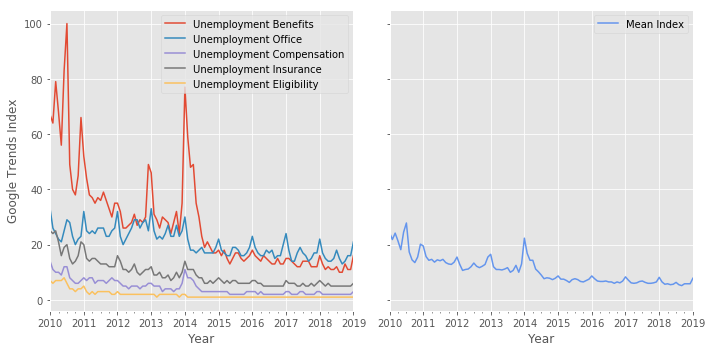

In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5), sharey = True)
us.plot(ax = ax[0])
us_mean.plot(ax = ax[1], label = 'Mean Index', color = 'cornflowerblue')
ax[0].legend(['Unemployment Benefits', 'Unemployment Office', 'Unemployment Compensation',
              'Unemployment Insurance', 'Unemployment Eligibility'])
ax[0].set_ylabel('Google Trends Index')
ax[0].set_xlabel('Year')
ax[1].legend(['Mean Index'])
ax[1].set_xlabel('Year')

plt.tight_layout()

In [0]:
# Now, I use the mean index for each US state, and merge the time series into one dataset

state_codes = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
               "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
               "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
               "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
               "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
state_list = ['US-{}'.format(x) for x in state_codes]

google_index = us_mean 

for i,j in enumerate(state_list):
  pytrends.build_payload(kw_list = keywords, geo = state_list[i], timeframe = '2010-01-01 2019-01-31')
  state = pytrends.interest_over_time()
  state_mean = state.mean(axis = 1)
  state_mean = state_mean.to_frame(name = j)
  google_index = google_index.merge(state_mean, right_index = True, left_index = True)

google_index.columns = ["US"] + list_states 

In [11]:
# Merge the google index data to the unemployment data 
import pandas as pd
pd.options.display.max_columns = None

data = unrate.merge(google_index, left_index = True, right_index = True)
data.head()


,US_x,Alabama_x,Alaska_x,Arizona_x,Arkansas_x,California_x,Colorado_x,Connecticut_x,Delaware_x,District of Columbia_x,Florida_x,Georgia_x,Hawaii_x,Idaho_x,Illinois_x,Indiana_x,Iowa_x,Kansas_x,Kentucky_x,Louisiana_x,Maine_x,Maryland_x,Massachusetts_x,Michigan_x,Minnesota_x,Mississippi_x,Missouri_x,Montana_x,Nebraska_x,Nevada_x,New Hampshire_x,New Jersey_x,New Mexico_x,New York_x,North Carolina_x,North Dakota_x,Ohio_x,Oklahoma_x,Oregon_x,Pennsylvania_x,Rhode Island_x,South Carolina_x,South Dakota_x,Tennessee_x,Texas_x,Utah_x,Vermont_x,Virginia_x,Washington_x,West Virginia_x,Wisconsin_x,Wyoming_x,US_y,Alabama_y,Alaska_y,Arizona_y,Arkansas_y,California_y,Colorado_y,Connecticut_y,Delaware_y,District of Columbia_y,Florida_y,Georgia_y,Hawaii_y,Idaho_y,Illinois_y,Indiana_y,Iowa_y,Kansas_y,Kentucky_y,Louisiana_y,Maine_y,Maryland_y,Massachusetts_y,Michigan_y,Minnesota_y,Mississippi_y,Missouri_y,Montana_y,Nebraska_y,Nevada_y,New Hampshire_y,New Jersey_y,New Mexico_y,New York_y,North Carolina_y,North Dakota_y,Ohio_y,Oklahoma_y,Oregon_y,Pennsylvania_y,Rhode Island_y,South Carolina_y,South Dakota_y,Tennessee_y,Texas_y,Utah_y,Vermont_y,Virginia_y,Washington_y,West Virginia_y,Wisconsin_y,Wyoming_y
2010-01-01,9.8,12.3,8.9,11.1,9.0,12.7,8.9,9.5,9.3,10.2,11.5,10.9,7.2,10.5,12.2,11.8,7.3,7.7,11.5,8.2,9.2,8.1,9.6,14.4,8.5,11.7,10.3,8.4,5.4,13.5,7.0,10.3,8.1,9.6,12.0,4.8,12.0,7.6,11.9,9.5,12.1,12.4,5.9,11.2,8.6,8.4,7.0,7.9,11.3,9.4,10.1,8.1,24.333333,30.833333,29.500000,17.666667,17.666667,22.333333,23.166667,26.166667,26.500000,17.000000,16.166667,17.500000,22.500000,18.500000,22.666667,18.166667,22.000000,29.666667,25.166667,33.666667,15.666667,24.833333,21.000000,20.166667,27.666667,11.500000,25.000000,33.333333,18.000000,24.000000,21.166667,17.833333,32.166667,20.166667,24.500000,18.166667,22.333333,28.333333,38.166667,27.333333,27.000000,29.333333,31.500000,20.833333,16.833333,25.666667,15.000000,27.000000,26.166667,35.500000,44.333333,25.666667
2010-02-01,9.8,12.1,9.1,10.7,9.0,12.6,8.9,9.5,9.4,9.9,11.2,10.9,6.9,10.4,11.9,11.8,7.1,7.5,11.9,7.2,9.5,8.3,9.2,14.2,8.4,11.3,10.5,8.4,5.3,13.5,6.9,10.3,8.1,9.5,12.0,4.8,11.9,7.6,11.9,9.5,11.9,12.1,5.9,10.8,8.4,8.3,6.9,7.9,11.2,10.0,10.4,7.8,21.833333,26.666667,22.666667,13.166667,12.333333,20.166667,25.166667,22.333333,23.833333,16.666667,15.333333,16.500000,31.166667,17.166667,21.500000,14.000000,28.500000,18.833333,23.166667,30.666667,20.500000,19.666667,16.666667,19.333333,23.500000,12.666667,20.500000,22.666667,18.666667,17.166667,18.166667,17.000000,24.666667,19.500000,24.333333,25.500000,20.666667,26.333333,26.666667,25.166667,15.500000,22.833333,27.500000,17.666667,15.333333,21.833333,18.666667,19.000000,21.500000,26.166667,37.833333,30.166667
2010-03-01,9.9,11.5,8.9,10.4,8.3,12.6,9.1,9.2,9.0,9.5,11.0,10.4,6.9,10.0,11.5,11.6,6.9,7.5,11.0,7.3,9.2,8.1,8.9,14.1,8.6,10.8,10.2,8.4,5.2,13.6,6.7,10.1,8.2,9.1,11.5,4.8,11.4,7.0,11.9,9.2,11.7,11.5,5.9,10.6,8.3,8.4,7.0,7.7,10.9,9.3,10.3,7.6,24.166667,25.166667,14.833333,16.333333,12.500000,20.833333,20.000000,23.833333,25.000000,18.000000,16.666667,18.333333,23.333333,15.500000,25.500000,16.666667,22.500000,26.166667,25.833333,26.166667,17.500000,26.166667,24.166667,23.333333,21.333333,11.833333,19.333333,19.333333,22.833333,14.333333,24.166667,19.500000,14.000000,24.500000,28.000000,15.166667,22.500000,31.500000,27.333333,29.000000,17.666667,24.166667,20.666667,22.833333,17.166667,19.166667,18.833333,21.666667,23.833333,21.333333,30.500000,29.333333
2010-04-01,9.9,10.4,8.3,10.1,7.8,12.0,8.5,8.9,8.5,8.7,10.6,9.9,6.7,9.4,10.5,10.6,5.9,6.9,10.0,7.1,8.5,7.3,8.3,12.9,7.5,9.8,9.3,7.5,4.6,13.4,5.9,9.4,7.9,8.5,10.9,3.8,10.4,6.5,11.0,8.3,11.2,10.9,4.9,9.6,7.9,7.8,6.6,7.0,10.0,8.4,9.0,7.0,21.333333,27.333333,18.666667,13.833333,12.000000,20.000000,20.000000,18.833333,23.000000,11.666667,15.333333,20.000000,20.333333,15.333333,22.166667,13.666667,19.166667,17.833333,22.000000,27.000000,19.333333,24.166667,17.500000,18.666667,16.333333,10.666667,19.500000,28.000000,



> It would be interesting to see how correlated Google Index results are correlated with the unemployment rates. If the correlation is positive and strong, there is a good reason to use it as an additional explanatory variable in our model. However, if the index is fully correlated with unemployment, it will not add any more information. 



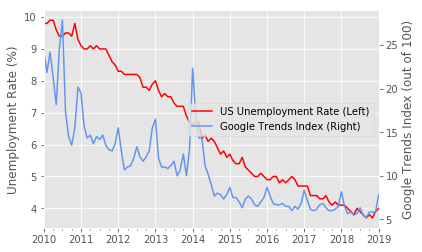

In [12]:
# Graphically

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.style.use('ggplot')

ax2 = ax.twinx()


data.plot(kind = 'line', y = 'US_x', ax = ax, color = 'red', label='US Unemployment Rate (Left)')
data.plot(kind = 'line', y = 'US_y', ax = ax2, color = 'cornflowerblue', label='Google Trends Index (Right)')

ax.set_ylabel('Unemployment Rate (%)')
ax2.set_ylabel('Google Trends Index (out of 100)')

ax2.grid(None)

'''Legend'''
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.get_legend().remove()
ax.get_legend().remove()
plt.legend(lines + lines2, labels + labels2, loc = 'right')


In [13]:
# Numerically

corr_vector = []
for i in list_states:
  corr = data['{}_x'.format(i)].corr(data['{}_y'.format(i)])
  corr_vector.append(corr)

corr = pd.Series(corr_vector).to_frame(name = 'Correlation')
c = corr.mean(axis = 0)
print('Mean Correlation between Google Trends Index and State-level Unemployment Rates is: \n', c) 

Mean Correlation between Google Trends Index and State-level Unemployment Rates is: 
 Correlation    0.762996
dtype: float64


## Models 

The outcome variable of our models will always be US national unemployment rate. All models use the Multi-Layer Perceptron network.

- **Model 1** uses past values of US state unemployment rate to forecast US national unemployment next month

- **Model 2** uses past values of US state unemployment rate and US state Google Index values to forecast US national unemployment next month

- **Model 3** uses past values of US state unemployment rate and US state Google Index values in the current and previous two months to forecast US national unemployment next month

Choice of parameters:

- **Number of layers**: I chose 2 layers (1 hidden) because this simple neural network architecture can be a universal approximator for any given function in $R^n$. 
- **Number of inputs**: The number of inputs per layer is not very important as long as it is large enough. I tested numbers above 50 and the results are unchanged. Only when choosing values closer to 10 or 20 is there any clear deterioration in the MSE results. 
- **Alpha penalization parameter**: Initially, this parameter was set at 0.001, which lead to very low MSE on the train data (over-fitting). Every time I multiplied it by a factor of 10, the MSE train improved and it stopped improving for alpha's greater than 1. An interesting outcome of increasing the alpha is that the MSE of Models 1 and 2 started converging. 
- **Activation function**: I chose the logistic function as it is part of the standard sigmoid function family. 
- **Max Iterations**: Initially, I chose 100 iterations, then varied the number up to 10,000. There is no significant improvement after 1,000 iterations. 
- **Solver**: The LBFGS algorithm works better for small datasets. 





### Model 1
<a id='Model 1'></a>

In [0]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn import neural_network
from sklearn import metrics

In [0]:
def model1(lag):
  
  df = data.copy() 
  
  '''Forecast Horizon''' 
  # First, choose the forecast period (1, 2, or 3 months ahead), and lag the US  
  # national unemployment rate by that period

  df['US_x'] = df['US_x'].shift(-lag)
   
  '''Scaling the data'''
  # Notice that I apply the Scaler to the Train and Test data separately 
  scaler = StandardScaler()

  '''Prepare the train data'''
  split_date = pd.Timestamp('2017-01-01')
  train = df.loc[ :split_date] 
  train_clean = train.drop(['US_y']+['{}_y'.format(x) for x in list_states], axis = 1).copy()
  train_sc = scaler.fit_transform(train_clean)
  train_sc = pd.DataFrame(train_sc)
  train_sc['date'] = train.index
  train_sc.set_index('date', inplace = True)
  
  X_train = train_sc.drop([0], axis = 1).copy() 
  y_train = train_sc.drop(list(range(1,52)), axis = 1).copy()

  '''Prepare the test data'''
  test = df.loc[split_date: ]
  test_clean = test.drop(['US_y']+['{}_y'.format(x) for x in list_states], axis = 1).copy()
  test_sc = scaler.fit_transform(test_clean)
  test_sc = pd.DataFrame(test_sc)
  test_sc['date'] = test.index
  test_sc.set_index('date', inplace = True)
  test_sc = test_sc[:-lag]

  X_test = test_sc.drop([0], axis = 1).copy()
  y_test = test_sc.drop(list(range(1,52)), axis = 1).copy()

  '''Parameters for Neural Network'''
  _alpha = 1
  _activation = "logistic"
  _max_iter = 10000
  _solver = 'lbfgs'

  '''Fitting the MLP model'''
  nn_model = neural_network.MLPRegressor((50, 50), activation = _activation, 
                                         solver = _solver, alpha = _alpha,  max_iter = _max_iter)
  
  return (nn_model, X_train, y_train, X_test, y_test)


In [0]:
def model1_mse(lag):
  
  nn_model, X_train, y_train, X_test, y_test = model1(lag)
  nn_model.fit(X_train, y_train)
  
  '''View MSE for Train and Test data'''
  mse_train = metrics.mean_squared_error(y_train, nn_model.predict(X_train))
  mse_test = metrics.mean_squared_error(y_test, nn_model.predict(X_test))
  
  return [mse_train, mse_test]

def model1_plt(lag):
  
  nn_model, X_train, y_train, X_test, y_test = model1(lag)
  nn_model.fit(X_train, y_train)
  
  '''Plot the True and Predicted values in the Test data'''
  nn_y_pred_test = nn_model.predict(X_test)
  nn_y_pred_test = pd.DataFrame(nn_y_pred_test)
   
  nn_y_pred_test['date'] = y_test.index
  nn_y_pred_test.set_index('date', inplace = True)
 
  plt.plot(y_test.shift(periods = lag), label = 'True', color = 'red')
  plt.plot(nn_y_pred_test.shift(periods = lag), label = '{}-Month Forecast'.format(lag), 
          color = 'mediumturquoise')

### Model 2

In [0]:
def model2(lag):
  
  df = data.copy() 
  
  '''Forecast Horizon''' 
  # First, choose the forecast period (1, 2, or 3 months ahead), and lag the US  
  # national unemployment rate by that period

  df['US_x'] = df['US_x'].shift(-lag)
   
  '''Scaling the data'''
  # Notice that I apply the Scaler to the Train and Test data separately 
  scaler = StandardScaler()

  '''Prepare the train data'''
  split_date = pd.Timestamp('2017-01-01')
  train = df.loc[ :split_date] 
  train_clean = train.drop(['US_y'], axis = 1).copy()
  train_sc = scaler.fit_transform(train_clean)
  train_sc = pd.DataFrame(train_sc)
  train_sc['date'] = train.index
  train_sc.set_index('date', inplace = True)

  X_train = train_sc.drop([0], axis = 1).copy() 
  y_train = train_sc.drop(list(range(1,103)), axis = 1).copy()

  '''Prepare the test data'''
  test = df.loc[split_date: ]
  test_clean = test.drop(['US_y'], axis = 1).copy()
  test_sc = scaler.fit_transform(test_clean)
  test_sc = pd.DataFrame(test_sc)
  test_sc['date'] = test.index
  test_sc.set_index('date', inplace = True)
  test_sc = test_sc[:-lag]

  X_test = test_sc.drop([0], axis = 1).copy()
  y_test = test_sc.drop(list(range(1,103)), axis = 1).copy()

  '''Parameters for Neural Network'''
  _alpha = 1
  _activation = "logistic"
  _max_iter = 10000 
  _solver = 'lbfgs'

  '''Fitting the MLP model'''
  nn_model = neural_network.MLPRegressor((50, 50), activation = _activation, 
                                         solver = _solver, alpha = _alpha,  max_iter = _max_iter)
  
  return (nn_model, X_train, y_train, X_test, y_test)


In [0]:
def model2_mse(lag):
  
  nn_model, X_train, y_train, X_test, y_test = model2(lag)
  nn_model.fit(X_train, y_train)
  
  '''View MSE for Train and Test data'''
  mse_train = metrics.mean_squared_error(y_train, nn_model.predict(X_train))
  mse_test = metrics.mean_squared_error(y_test, nn_model.predict(X_test))
  
  return [mse_train, mse_test]

def model2_plt(lag):
  
  nn_model, X_train, y_train, X_test, y_test = model2(lag)
  nn_model.fit(X_train, y_train)
  
  '''Plot the True and Predicted values in the Test data'''
  nn_y_pred_test = nn_model.predict(X_test)
  nn_y_pred_test = pd.DataFrame(nn_y_pred_test)
   
  nn_y_pred_test['date'] = y_test.index
  nn_y_pred_test.set_index('date', inplace = True)
 
  plt.plot(nn_y_pred_test.shift(periods = lag), label = '{}-Month Forecast - Google Index'.format(lag), 
          color = 'cornflowerblue')

### Model 3

In [0]:
def model3(lag):
  
  df = data.copy() 
  df = df.drop(['US_y'], axis = 1)

  '''Create data for t-1 and t-2 '''
  df1 = df.shift(1)
  name_col = df1.columns 
  name_col = [s + "_1" for s in name_col]
  df1.columns = name_col
  
  df2 = df.shift(2)
  name_col = df2.columns 
  name_col = [s + "_2" for s in name_col]
  df2.columns = name_col
  
  df = pd.concat([df, df1, df2], axis=1)
  
  '''Forecast Horizon''' 
  # First, choose the forecast period (1, 2, or 3 months ahead), and lag the US  
  # national unemployment rate by that period
  
  df['US_x'] = df['US_x'].shift(-lag)
  df.dropna(axis = 0, inplace = True)
  
  '''Scaling the data'''
  # Notice that I apply the Scaler to the Train and Test data separately 
  scaler = StandardScaler()
  
  '''Prepare the train data'''
  split_date = pd.Timestamp('2017-01-01')
  train = df.loc[ :split_date] 
  train_sc = scaler.fit_transform(train)
  train_sc = pd.DataFrame(train_sc)
  train_sc['date'] = train.index
  train_sc.set_index('date', inplace = True)

  X_train = train_sc.drop([0], axis = 1).copy() 
  y_train = train_sc.drop(list(range(1,309)), axis = 1).copy()

  '''Prepare the test data'''
  test = df.loc[split_date: ]
  test_sc = scaler.fit_transform(test)
  test_sc = pd.DataFrame(test_sc)
  test_sc['date'] = test.index
  test_sc.set_index('date', inplace = True)
  test_sc = test_sc[:-lag]

  X_test = test_sc.drop([0], axis = 1).copy()
  y_test = test_sc.drop(list(range(1,309)), axis = 1).copy()

  '''Parameters for Neural Network'''
  _alpha = 1
  _activation = "logistic"
  _max_iter = 10000 
  _solver = 'lbfgs'

  '''Fitting the MLP model'''
  nn_model = neural_network.MLPRegressor((50, 50), activation = _activation, 
                                         solver = _solver, alpha = _alpha,  max_iter = _max_iter)
  
  return (nn_model, X_train, y_train, X_test, y_test)


In [0]:
def model3_mse(lag):
  
  nn_model, X_train, y_train, X_test, y_test = model3(lag)
  nn_model.fit(X_train, y_train)
  
  '''View MSE for Train and Test data'''
  mse_train = metrics.mean_squared_error(y_train, nn_model.predict(X_train))
  mse_test = metrics.mean_squared_error(y_test, nn_model.predict(X_test))
  
  return [mse_train, mse_test]

def model3_plt(lag):
  
  nn_model, X_train, y_train, X_test, y_test = model3(lag)
  nn_model.fit(X_train, y_train)
  
  '''Plot the True and Predicted values in the Test data'''
  nn_y_pred_test = nn_model.predict(X_test)
  nn_y_pred_test = pd.DataFrame(nn_y_pred_test)
   
  nn_y_pred_test['date'] = y_test.index
  nn_y_pred_test.set_index('date', inplace = True)
 
  plt.plot(nn_y_pred_test.shift(periods = lag), label = '{}-Month Forecast - Google Index - Past Values'.format(lag), 
          color = 'tab:purple')

## MSE Comparison

In [21]:
import warnings
warnings.filterwarnings('ignore')

## MSE results 
 
mse_list1 = []
for _lag in range(1,4):
  mse = model1_mse(lag = _lag)
  mse_list1.append(mse)

mse_list1 = pd.DataFrame(mse_list1)
mse_list1.index = ['1-month forecast', '2-month forecast', '3-month forecast']
mse_list1.columns = ['MSE Train', 'MSE Test']
mse_list1

mse_list2 = []
for _lag in range(1,4):
  mse = model2_mse(lag = _lag)
  mse_list2.append(mse)

mse_list2 = pd.DataFrame(mse_list2)
mse_list2.index = ['1-month forecast', '2-month forecast', '3-month forecast']
mse_list2.columns = ['MSE Train', 'MSE Test']

mse_list3 = []
for _lag in range(1,4):
  mse = model3_mse(lag = _lag)
  mse_list3.append(mse)

mse_list3 = pd.DataFrame(mse_list3)
mse_list3.index = ['1-month forecast', '2-month forecast', '3-month forecast']
mse_list3.columns = ['MSE Train', 'MSE Test']

mse = mse_list1.merge(mse_list2, left_index = True, right_index = True)
mse = mse.merge(mse_list3, left_index = True, right_index = True)

models = ['Model1', 'Model2', 'Model3']
mse.columns = pd.MultiIndex.from_product([models, mse_list1.columns])
mse

Model1              Model2              Model3          
                 MSE Train  MSE Test MSE Train  MSE Test MSE Train  MSE Test
1-month forecast  0.022589  0.491333  0.018063  0.442910  0.008238  0.386611
2-month forecast  0.025131  0.724105  0.018332  0.652488  0.008118  0.476660
3-month forecast  0.025455  0.824748  0.019124  0.746085  0.008547  0.379550

## Graphic Comparison

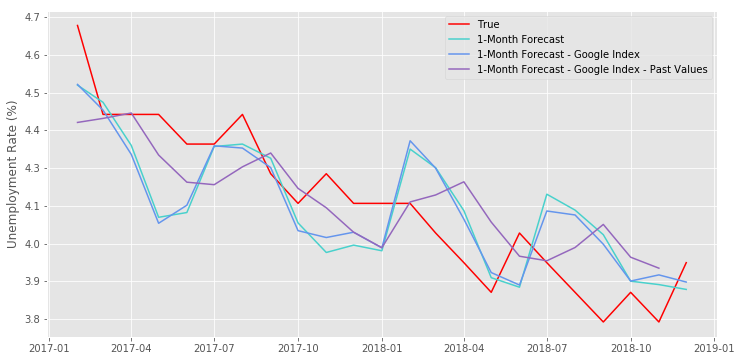

In [22]:
## One-month forecasts

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (12,6))
model1_plt(lag = 1)
model2_plt(lag = 1)
model3_plt(lag = 1)
ax.legend()
ax.set_ylabel('Unemployment Rate (%)')


ax.set_yticklabels(list(np.round(np.linspace(3.7, 4.7, 10), decimals = 1)))
ax.spines['right'].set_visible(False)

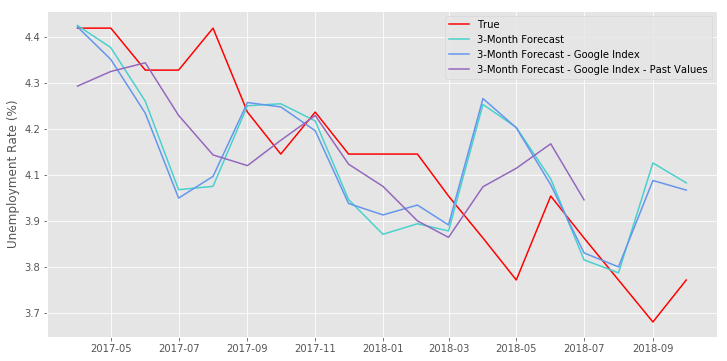

In [23]:
## Three-month forecasts

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (12,6))
model1_plt(lag = 3)
model2_plt(lag = 3)
model3_plt(lag = 3)

ax.legend()
ax.set_ylabel('Unemployment Rate (%)')

ax.set_yticklabels(list(np.round(np.linspace(3.6, 4.4, 8), decimals = 1)))
ax.spines['right'].set_visible(False)

## Conclusion

Model 2 is an improvement on Model 1, which points to the usefulness of Google Index data in forecating short-term unemployment rates. 

Model 3 is a leap from the previous two models, showing that historical data is very useful in MLP networks that do not have memory features, such as the LSTM architecture. 

A potential area of improvement would be to use an LSTM model which has 'memory' of previous patterns and is more suitable to time series data.